In [1]:
# dataset  generation
import csv
import cv2
import glob
import os
import xml.etree.ElementTree as ET

import numpy as np

In [2]:
DATASET_FOLDER = "/hrnas_user/users/subhajit/python_training/cat_dog_dataset/training_images/"
TRAIN_OUTPUT_FILE = "/hrnas_user/users/subhajit/python_training/object_detection/train.csv"
VALIDATION_OUTPUT_FILE = "/hrnas_user/users/subhajit/python_training/object_detection/validation.csv"

SPLIT_RATIO = 0.8

In [3]:
def main():
    if not os.path.exists(DATASET_FOLDER):
        print("Dataset not found")
        return

    class_names = {}
    k = 0
    output = []
    xml_files = glob.glob("{}/*xml".format(DATASET_FOLDER))
    for i, xml_file in enumerate(xml_files):
        tree = ET.parse(xml_file)

        path = os.path.join(DATASET_FOLDER, xml_file.split('.')[0] + '.jpg')

        height = int(tree.findtext("./size/height"))
        width = int(tree.findtext("./size/width"))
        xmin = int(tree.findtext("./object/bndbox/xmin"))
        ymin = int(tree.findtext("./object/bndbox/ymin"))
        xmax = int(tree.findtext("./object/bndbox/xmax"))
        ymax = int(tree.findtext("./object/bndbox/ymax"))

        basename = os.path.basename(path)
        basename = os.path.splitext(basename)[0]
        class_name = basename[:basename.rfind("_")].lower()
        if class_name not in class_names:
            class_names[class_name] = k
            k += 1

        output.append((path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]))

    # preserve percentage of samples for each class ("stratified")
    output.sort(key=lambda tup : tup[-1])

    lengths = []
    i = 0
    last = 0
    for j, row in enumerate(output):
        if last == row[-1]:
            i += 1
        else:
            print("class {}: {} images".format(output[j-1][-2], i))
            lengths.append(i)
            i = 1
            last += 1

    print("class {}: {} images".format(output[j-1][-2], i))
    lengths.append(i)

    with open(TRAIN_OUTPUT_FILE, "w", newline='') as train, open(VALIDATION_OUTPUT_FILE, "w", newline='') as validate:
        writer = csv.writer(train, delimiter=",")
        writer2 = csv.writer(validate, delimiter=",")

        s = 0
        for c in lengths:
            for i in range(c):
                print("{}/{}".format(s + 1, sum(lengths)), end="\r")

                path, height, width, xmin, ymin, xmax, ymax, class_name, class_id = output[s]

                if xmin >= xmax or ymin >= ymax or xmax > width or ymax > height or xmin < 0 or ymin < 0:
                    print("Warning: {} contains invalid box. Skipped...".format(path))
                    continue

                row = [path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]]
                if i <= c * SPLIT_RATIO:
                    writer.writerow(row)
                else:
                    writer2.writerow(row)

                s += 1

    print("\nDone!")

In [4]:
if __name__ == "__main__":
    main()

class dog: 69 images
class cat: 89 images
158/158
Done!


In [5]:
#importing libaries for deep learning
import csv
import math

from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Dense, GlobalAveragePooling2D, Input, Activation 
from tensorflow.keras.layers import BatchNormalization, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import epsilon
from matplotlib import pyplot as plt

In [6]:
IMG_SIZE = 224

EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = False
THREADS = 1

TRAIN_CSV = "/hrnas_user/users/subhajit/python_training/object_detection/train.csv"
VALIDATION_CSV = "/hrnas_user/users/subhajit/python_training/object_detection/validation.csv"

CLASSES = 2

In [7]:
class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []
        IMAGE_SIZE = IMG_SIZE
        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4 + CLASSES))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, class_id = row
                self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
                self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
                self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                self.coords[index, min(4 + int(class_id), self.coords.shape[1]-1)] = 1

                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        IMAGE_SIZE = IMG_SIZE
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, [batch_coords[...,:4], batch_coords[...,4:]]

In [8]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        accuracy = 0

        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, (gt, class_id) = self.generator[i]
            pred, pred_class = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy

        print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))

In [9]:
def create_model(IMG_SIZE):
    inputShape= (IMG_SIZE, IMG_SIZE,3)
    chanDim = -1
    inputs = Input(shape=inputShape)
    x = Conv2D(64, (3, 3), padding="same",input_shape=(IMG_SIZE, IMG_SIZE,3))(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x=Flatten()(x)
    x=Dense(1000, activation='sigmoid')(x)
    x=Dense(800, activation='sigmoid')(x)
    
    y1 = Dense(4, name="coords")(x)

    y2 = Dense(CLASSES, name="classes", activation="softmax")(x)

    return Model(inputs, outputs=[y1, y2])

In [10]:
def log_mse(y_true, y_pred):
    return tf.reduce_mean(tf.math.log1p(tf.math.squared_difference(y_pred, y_true)), axis=-1)

def focal_loss(alpha=0.9, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

In [11]:
def main():
    model = create_model(IMG_SIZE)

    train_datagen = DataGenerator(TRAIN_CSV)
    validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss={"coords" : log_mse, "classes" : focal_loss()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=[])
    checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max")
    stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
    reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

    model.summary()

    history=model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
                        verbose=1)
    model.save("model.h5")
     #list all data in history
    print(history.history.keys())
# summarize history for accuracy
   # plt.plot(history.history['acc'])
    plt.plot(history.history['val_iou'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
   # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(history.history['val_mse'])
    plt.title('validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
model = create_model(IMG_SIZE)

train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={"coords" : log_mse, "classes" : focal_loss()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=[])
checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max")
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         activation[0][0]                 
______________________________________________________________________________________________

In [13]:
history=model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
                        verbose=1)

Epoch 1/200
3/4 [=====================>........] - ETA: 1s - loss: 7.8823 - coords_loss: 7.8277 - classes_loss: 0.0546 - val_iou: 0.0 - val_mse: 30.2011 - val_acc: 0.5667

Epoch 00001: val_iou improved from -inf to 0.00000, saving model to model-0.00.h5
4/4 [==============================] - 10s 2s/step - loss: 9.5172 - coords_loss: 7.8473 - classes_loss: 1.6698
Epoch 2/200
3/4 [=====================>........] - ETA: 1s - loss: 10.0531 - coords_loss: 7.7049 - classes_loss: 2.3482   - val_iou: 0.0001 - val_mse: 29.7097 - val_acc: 0.5667

Epoch 00002: val_iou improved from 0.00000 to 0.00010, saving model to model-0.00.h5
4/4 [==============================] - 9s 2s/step - loss: 9.3902 - coords_loss: 7.6290 - classes_loss: 1.7612
Epoch 3/200
3/4 [=====================>........] - ETA: 1s - loss: 7.8953 - coords_loss: 7.4898 - classes_loss: 0.4055 - val_iou: 0.0001 - val_mse: 29.4366 - val_acc: 0.5667

Epoch 00003: val_iou did not improve from 0.00010
4/4 [==============================] 

4/4 [==============================] - 8s 2s/step - loss: 6.0684 - coords_loss: 5.9712 - classes_loss: 0.0972
Epoch 24/200
3/4 [=====================>........] - ETA: 1s - loss: 5.9653 - coords_loss: 5.8767 - classes_loss: 0.0886 - val_iou: 0.1463 - val_mse: 16.6788 - val_acc: 0.5667

Epoch 00024: val_iou improved from 0.13410 to 0.14630, saving model to model-0.15.h5
4/4 [==============================] - 8s 2s/step - loss: 6.0862 - coords_loss: 5.9085 - classes_loss: 0.1778
Epoch 25/200
3/4 [=====================>........] - ETA: 1s - loss: 6.1368 - coords_loss: 5.8995 - classes_loss: 0.2373 - val_iou: 0.1723 - val_mse: 15.813 - val_acc: 0.5

Epoch 00025: val_iou improved from 0.14630 to 0.17230, saving model to model-0.17.h5
4/4 [==============================] - 8s 2s/step - loss: 6.0823 - coords_loss: 5.8820 - classes_loss: 0.2003
Epoch 26/200
3/4 [=====================>........] - ETA: 1s - loss: 5.9170 - coords_loss: 5.8266 - classes_loss: 0.0904 - val_iou: 0.1856 - val_mse: 15.

3/4 [=====================>........] - ETA: 1s - loss: 5.7589 - coords_loss: 5.7220 - classes_loss: 0.0369 - val_iou: 0.1706 - val_mse: 15.9052 - val_acc: 0.5333

Epoch 00047: val_iou did not improve from 0.19370
4/4 [==============================] - 6s 2s/step - loss: 5.7795 - coords_loss: 5.7407 - classes_loss: 0.0388
Epoch 48/200
3/4 [=====================>........] - ETA: 1s - loss: 5.7982 - coords_loss: 5.7597 - classes_loss: 0.0385 - val_iou: 0.1693 - val_mse: 15.9297 - val_acc: 0.5667

Epoch 00048: val_iou did not improve from 0.19370

Epoch 00048: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
4/4 [==============================] - 6s 2s/step - loss: 5.7747 - coords_loss: 5.7376 - classes_loss: 0.0371
Epoch 49/200
3/4 [=====================>........] - ETA: 1s - loss: 5.7722 - coords_loss: 5.7351 - classes_loss: 0.0371 - val_iou: 0.169 - val_mse: 15.9353 - val_acc: 0.5667

Epoch 00049: val_iou did not improve from 0.19370
4/4 [=============================

Epoch 71/200
3/4 [=====================>........] - ETA: 1s - loss: 5.7556 - coords_loss: 5.7205 - classes_loss: 0.0350 - val_iou: 0.1677 - val_mse: 15.9659 - val_acc: 0.5667

Epoch 00071: val_iou did not improve from 0.19370
4/4 [==============================] - 6s 2s/step - loss: 5.7585 - coords_loss: 5.7253 - classes_loss: 0.0333
Epoch 72/200
3/4 [=====================>........] - ETA: 1s - loss: 5.7572 - coords_loss: 5.7241 - classes_loss: 0.0330 - val_iou: 0.1678 - val_mse: 15.9639 - val_acc: 0.5667

Epoch 00072: val_iou did not improve from 0.19370
4/4 [==============================] - 6s 2s/step - loss: 5.7586 - coords_loss: 5.7252 - classes_loss: 0.0333
Epoch 73/200
3/4 [=====================>........] - ETA: 1s - loss: 5.7387 - coords_loss: 5.7088 - classes_loss: 0.0298 - val_iou: 0.1679 - val_mse: 15.9616 - val_acc: 0.5667

Epoch 00073: val_iou did not improve from 0.19370
4/4 [==============================] - 6s 2s/step - loss: 5.7584 - coords_loss: 5.7249 - classes_loss:

In [14]:
#saving model
model.save("/hrnas_user/users/subhajit/python_training/object_detection/model.h5")

dict_keys(['loss', 'coords_loss', 'classes_loss', 'val_iou', 'val_mse', 'val_acc', 'lr'])


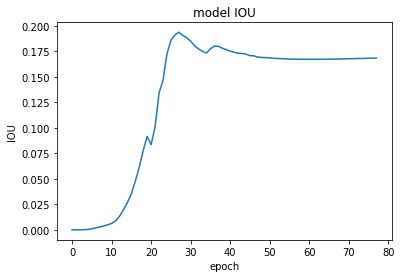

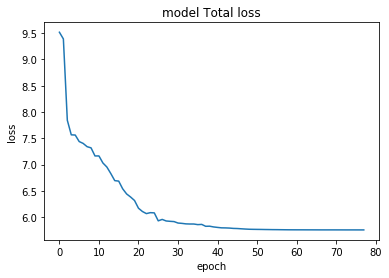

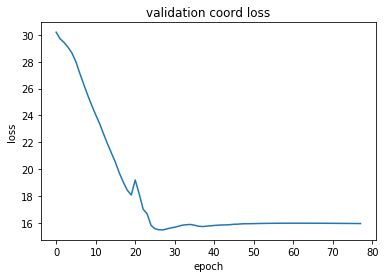

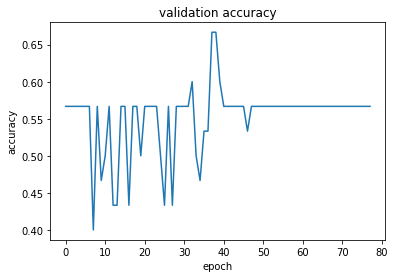

In [15]:
#plotting model parameters
print(history.history.keys())
# summarize history for accuracy
   # plt.plot(history.history['acc'])
plt.plot(history.history['val_iou'])
plt.title('model IOU')
plt.ylabel('IOU')
plt.xlabel('epoch')
   # plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model Total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_mse'])
plt.title('validation coord loss')
plt.ylabel('loss')
plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model testing
import cv2
import glob
from tensorflow.keras.models import load_model
filename='/hrnas_user/users/subhajit/python_training/cat_dog_dataset/images/images/yorkshire_terrier_74.jpg'
#model = load_model('/hrnas_user/users/subhajit/python_training/object_detection/model.h5')

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMG_SIZE, IMG_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

prediction = model.predict(feat_scaled[np.newaxis,:])

output = np.zeros(feat_scaled.shape, dtype=np.uint8)
# output[region > 0.5] = 1
region = prediction[0][0]
x0 = np.uint8(region[0]* unscaled.shape[1] / output.shape[1])
y0 = np.uint8(region[1]* unscaled.shape[0] / output.shape[0])
x1 = np.uint8(region[2]* unscaled.shape[1] / output.shape[1]) + x0
y1 = np.uint8(region[3]* unscaled.shape[0] / output.shape[0]) + y0

# contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# for cnt in contours:
#     approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
#     x, y, w, h = cv2.boundingRect(approx)

#     x0 = np.rint(x * unscaled.shape[1] / output.shape[1]).astype(int)
#     x1 = np.rint((x + w) * unscaled.shape[1] / output.shape[1]).astype(int)
#     y0 = np.rint(y * unscaled.shape[0] / output.shape[0]).astype(int)
#     y1 = np.rint((y + h) * unscaled.shape[0] / output.shape[0]).astype(int)
cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 255, 0), 1)

cv2.imshow("image", unscaled)
cv2.waitKey(0)

In [ ]:
feat_scaled.shape